## Compute monthly mean sea-ice concentration anomaly from EUMETSAT OSI SAF data

We compute monthly mean anomaly from EUMETSAT OSI SAF SIC CDR v3 data. This uses xarray.

**NB :** This software is for demonstration purpose only, it is not finalized for production.

In [1]:
import os
import xarray as xr
from datetime import date
import json
from copy import copy
import numpy as np

Configuration of the run

In [2]:
dt = date(2022,5,12)
area = 'nh'
outdir = '.'
indirs = None

# climo : years to include in the climatology run. **Both ends are included**.
climo = (1981, 2010)

In [3]:
# input monthly SIC files
fn_patt = 'ice_conc_{a:}_ease2-250_{c:}_{d:%Y%m}.nc'
fn_patt_src = {'cdr': 'cdr-v3p0', 'icdr': 'icdr-v3p0', 'icdrft': 'icdrft-v3p0'}

if indirs is None:
    inpdir_cdr = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/'
    inpdir_icdr = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/monthly/'
    # access through THREDDS/OpenDAP
    sources = {'cdr':inpdir_cdr,
              'icdr':inpdir_icdr,
              'icdrft':inpdir_icdr}
    jsond = json.dumps(sources, sort_keys=True, indent=4)
else:
    # load json file with path to input directories (if the daily SIC files are downloaded to a local disk)
    # an example json file (prepare_monthly_osisaf_sic_opendap.json) is provided to demonstrate the format
    #   expected for the json file (but the effect will be the same as setting indirs to None: read from
    #   THREDDS/opendap)
    with open(indirs, 'r') as f:
        sources = json.load(f)

In [4]:
def find_one_monthly_sic_file(dt, area):
    
    found_one_file = False
    for cdr in ('cdr', 'icdr', 'icdrft'):
        fn = fn_patt.format(a=area, d=dt, c=fn_patt_src[cdr])
        fn = os.path.join(sources[cdr],'{:%Y/}'.format(dt),fn)
        try:
            # this url exists, append it and move to next date
            ds = xr.open_dataset(fn)
            found_one_file = True
            return fn, cdr
        except OSError:
            # no valid file at this url, check the next rule
            # print("Failed with pattern {}".format(fn))
            pass
        
    # no file found. Add a warning (but we can continue)
    if not found_one_file:
        print("WARNING: could not find OSI SAF SIC v3 file for {} {}".format(area, dt))
        return None, None

def find_climo_monthly_sic_file(year_start, year_end, area, month):
    
    files = []
    for year in range(year_start, year_end+1):
        dt = date(year, month, 15)
        fn, src = find_one_monthly_sic_file(dt, area)
        if fn:
            files.append(fn)
    
    return files

fn, src = find_one_monthly_sic_file(dt, area)
climo_fns = find_climo_monthly_sic_file(climo[0], climo[1], area, dt.month)

if fn is None:
    raise ValueError("Found no file for target month.")

if len(climo_fns) == 0:
    raise ValueError("Found no files for climatology month.")

print(fn)
print(climo_fns)

https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/monthly/2022/ice_conc_nh_ease2-250_icdr-v3p0_202205.nc
['https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/1981/ice_conc_nh_ease2-250_cdr-v3p0_198105.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/1982/ice_conc_nh_ease2-250_cdr-v3p0_198205.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/1983/ice_conc_nh_ease2-250_cdr-v3p0_198305.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/1984/ice_conc_nh_ease2-250_cdr-v3p0_198405.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/1985/ice_conc_nh_ease2-250_cdr-v3p0_198505.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/1987/ice_conc_nh_ease2-250_cdr-v3p0_198705.nc', 'https://thredds.met.n

### Compute the anomaly

In [5]:
# A routine to reconstruct the unfiltered, unthresholded SICs from a OSI SAF SIC CDR file
def reconstruct_sic(ds):
    ice_conc = ds['ice_conc'].to_masked_array()
    raw_ice_conc_values = ds['raw_ice_conc_values'].to_masked_array()
    status_flag = ds['status_flag'].to_masked_array().astype('short')
    
    # combine ice_conc with raw_ice_conc_values using the status_flag
    new_ice_conc = copy(ice_conc)
    raw_100_mask = np.array((ice_conc==100) * (~raw_ice_conc_values.mask))
    new_ice_conc[raw_100_mask] = raw_ice_conc_values[raw_100_mask]
    
    new_ice_conc[(status_flag & 4) == 4] = raw_ice_conc_values[(status_flag & 4) == 4]

    # re-enter "full" ice_conc into the xarray dataset
    ds['ice_conc'][:] = new_ice_conc
    return ds

In [6]:
# read monthly mean field
month_ds = xr.open_dataset(fn, engine='netcdf4')
month_ds = reconstruct_sic(month_ds)

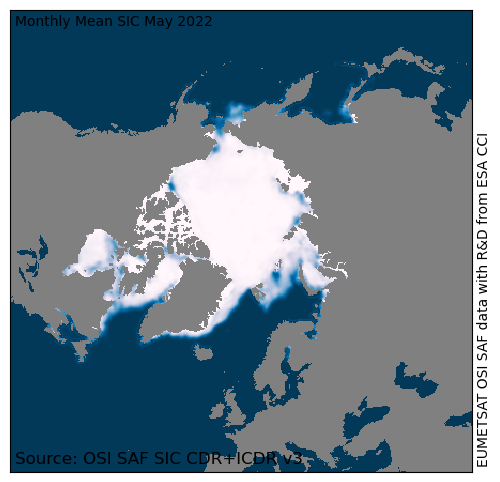

In [7]:
from matplotlib import pylab as plt
from cmocean import cm

cmap = copy(plt.colormaps['PuBu_r'])
cmap.set_bad('grey')

fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(month_ds['ice_conc'][0].to_masked_array(),
          interpolation='none', vmin=0, vmax=100, cmap=cmap)
ax.set_xticks([])
ax.set_yticks([])
ax.text(0.01,0.99,'Monthly Mean SIC {:%B %Y}'.format(dt,), va='top', transform=ax.transAxes)
ax.text(1.01,0.01,'EUMETSAT OSI SAF data with R&D from ESA CCI', rotation=90, ha='left', va='bottom', transform=ax.transAxes)
ax.text(0.01,0.01,'Source: OSI SAF SIC CDR+ICDR v3', fontsize=12, va='bottom', transform=ax.transAxes)
plt.show()

In [8]:
# compute climatological average
climo_ds = xr.open_mfdataset(climo_fns, engine='netcdf4')
climo_ds = reconstruct_sic(climo_ds)
climo_mean = climo_ds.mean(dim="time", keep_attrs=True)

In [9]:
# compute climatological anomaly
month_anomaly = month_ds - climo_mean

### Plot the anomaly

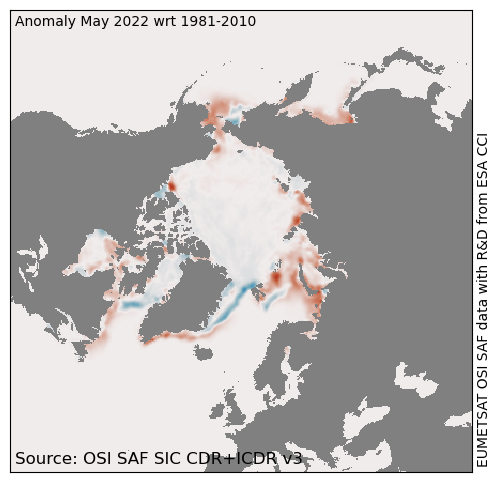

In [17]:
from matplotlib import pylab as plt
from cmocean import cm

cmap = copy(cm.balance_r)
cmap.set_bad('grey')

fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(month_anomaly['ice_conc'][0].to_masked_array(),
          interpolation='none', vmin=-100, vmax=+100, cmap=cmap)
ax.set_xticks([])
ax.set_yticks([])
ax.text(0.01,0.99,'Anomaly {:%B %Y} wrt {}-{}'.format(dt, *climo), va='top', transform=ax.transAxes)
ax.text(1.01,0.01,'EUMETSAT OSI SAF data with R&D from ESA CCI', rotation=90, ha='left', va='bottom', transform=ax.transAxes)
ax.text(0.01,0.01,'Source: OSI SAF SIC CDR+ICDR v3', fontsize=12, va='bottom', transform=ax.transAxes)
plt.show()

### Write to a netCDF file

Xarray datasets can be written to netCDF files with the to_netcdf() method.

TODO : add global attributes, check raw_ice_conc_values and status_flags, etc...

In [11]:
print(month_anomaly)

<xarray.Dataset>
Dimensions:                 (time: 1, xc: 432, yc: 432)
Coordinates:
  * time                    (time) datetime64[ns] 2022-05-16T12:00:00
  * xc                      (xc) float64 -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                      (yc) float64 5.388e+03 5.362e+03 ... -5.388e+03
    lat                     (yc, xc) float32 16.62 16.82 17.02 ... 16.82 16.62
    lon                     (yc, xc) float32 -135.0 -135.1 -135.3 ... 44.87 45.0
Data variables:
    Lambert_Azimuthal_Grid  float64 0.0
    ice_conc                (time, yc, xc) float64 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    raw_ice_conc_values     (time, yc, xc) float64 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    status_flag             (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>


In [12]:
outname = './sea_ice_concentration_anomaly_{}_{}{}_{:%Y%m}.nc'.format(area, climo[0], climo[1], dt)

In [13]:
# write to netCDF/CF
month_anomaly.to_netcdf(outname)

In [14]:
print(outname, "is ready.")

./sea_ice_concentration_anomaly_nh_19812010_202205.nc is ready.


### Plot the monthly mean SIC and the outline of the climatology median

In [15]:
climo_med = climo_ds.median(dim="time", keep_attrs=True)

/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


/home/thomasl/Downloads/test.tiff


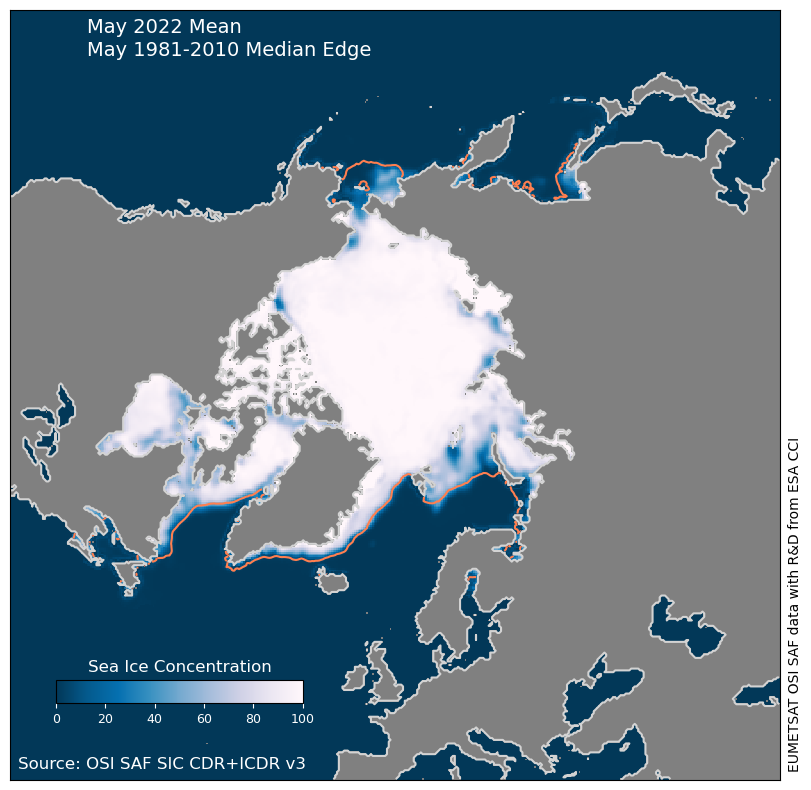

In [16]:
import numpy as np
from matplotlib import pylab as plt
from cmocean import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cmap = copy(cm.ice)
cmap = copy(plt.colormaps['PuBu_r'])
#cmap = copy(plt.colormaps['Blues_r'])
cmap.set_bad('grey')

with_median = True

fig, ax = plt.subplots(figsize=(10,10))
cols = ax.imshow(month_ds['ice_conc'][0].to_masked_array(),
          interpolation='none', vmin=0, vmax=100, cmap=cmap)
ax.contour(np.nan_to_num(month_ds['ice_conc'][0].values,nan=-10), levels=(-10.,),
           colors='lightgrey', linestyles='-')
if with_median:
    ax.contour(climo_med['ice_conc'], levels=(15.,), colors='coral',)

cbaxes = inset_axes(ax, width="32%", height="3%", loc=3, borderpad=0,
                    bbox_to_anchor=(0.06, 0.1, 1, 1),
                    bbox_transform=ax.transAxes)
cbar = plt.colorbar(cols, cax=cbaxes, orientation="horizontal",)
cbar.ax.set_title('Sea Ice Concentration',fontsize=12,color='w')
cbar.ax.tick_params(labelsize=9,colors='w')

ax.set_xticks([])
ax.set_yticks([])
ax.text(0.1,0.99,'{d:%B %Y} Mean'.format(d=dt),
        va='top', transform=ax.transAxes, color='w', fontsize=14,)
if with_median:
    ax.text(0.1,0.96,'{d:%B} {c1:}-{c2:} Median Edge'.format(d=dt, c1=climo[0], c2=climo[1]),
        va='top', transform=ax.transAxes, color='w', fontsize=14,)
ax.text(1.01,0.01,'EUMETSAT OSI SAF data with R&D from ESA CCI',
        rotation=90, ha='left', va='bottom', transform=ax.transAxes)
ax.text(0.01,0.01,'Source: OSI SAF SIC CDR+ICDR v3', fontsize=12,
        va='bottom', transform=ax.transAxes, color='w',)

outname = '/home/thomasl/Downloads/test.tiff'
plt.savefig(outname, bbox_inches='tight')
print(outname)

plt.show()